Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Skin Cancer

### Importing all the important libraries

In [1]:
#import all necessary libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
#Supress any Warnings
import warnings
warnings.filterwarnings('ignore')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration\Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration\Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
# train dataset
# seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory and
# resizing images to the size img_height*img_width
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,seed=123,validation_split= 0.2,subset= 'training',
            image_size=(img_height,img_width),batch_size = batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## validation dataset here
## seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## resizing images to the size img_height*img_width
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,seed=123,validation_split= 0.2,subset= 'validation',
            image_size=(img_height,img_width),batch_size = batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# all the classes of skin cancer and store them in a list.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Code to visualize one instance of all the nine classes present in the dataset

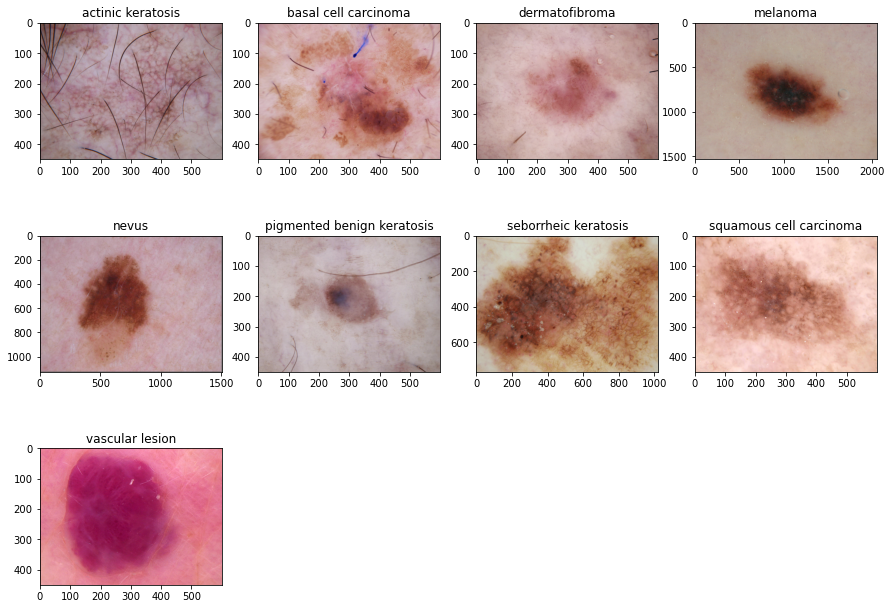

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(15,15))
for i in range(0,9): 
  plt.subplot(4, 4, i + 1)
  image = mpimg.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])

model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(num_classes, activation = "softmax"))

### Compile the model
Appropriate optimizer and loss function for model training 

In [12]:
# appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      6416      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

### Train the model

In [14]:
# model training with 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 115s 2s/step - loss: 2.0525 - accuracy: 0.1987 - val_loss: 2.0518 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 109s 2s/step - loss: 2.0190 - accuracy: 0.2148 - val_loss: 1.9958 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 108s 2s/step - loss: 1.9112 - accuracy: 0.2751 - val_loss: 1.8472 - val_accuracy: 0.3132
Epoch 4/20
56/56 [==============================] - 108s 2s/step - loss: 1.8113 - accuracy: 0.3069 - val_loss: 1.6527 - val_accuracy: 0.3937
Epoch 5/20
56/56 [==============================] - 113s 2s/step - loss: 1.6846 - accuracy: 0.3901 - val_loss: 1.6269 - val_accuracy: 0.4228
Epoch 6/20
56/56 [==============================] - 103s 2s/step - loss: 1.6658 - accuracy: 0.4046 - val_loss: 1.6060 - val_accuracy: 0.4139
Epoch 7/20
56/56 [==============================] - 103s 2s/step - loss: 1.6557 - accuracy: 0.3984 - val_loss: 1.5608 - val_accuracy: 0.4362
Epoch 8/20
56

### Visualizing training results

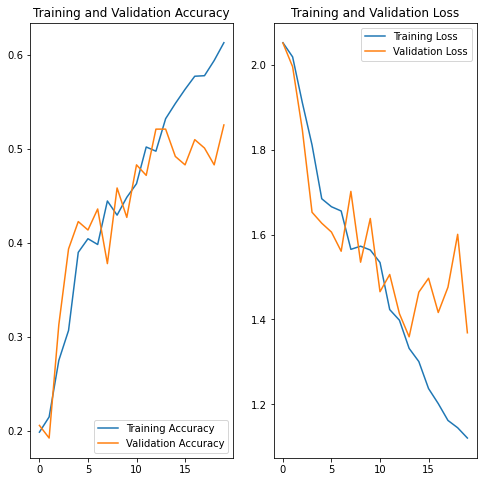

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings on the first base model
- The model is overfitting as we can see the difference in loss functions in training & test around the 19-20th epoch
- The accuracy is just around 50-60% because there are enough features to remember the pattern, and the neural network is very young (just 20 epochs), so the learning has just started

### Write your findings here

In [16]:
# after analyzing the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_aug = keras.Sequential([layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')])

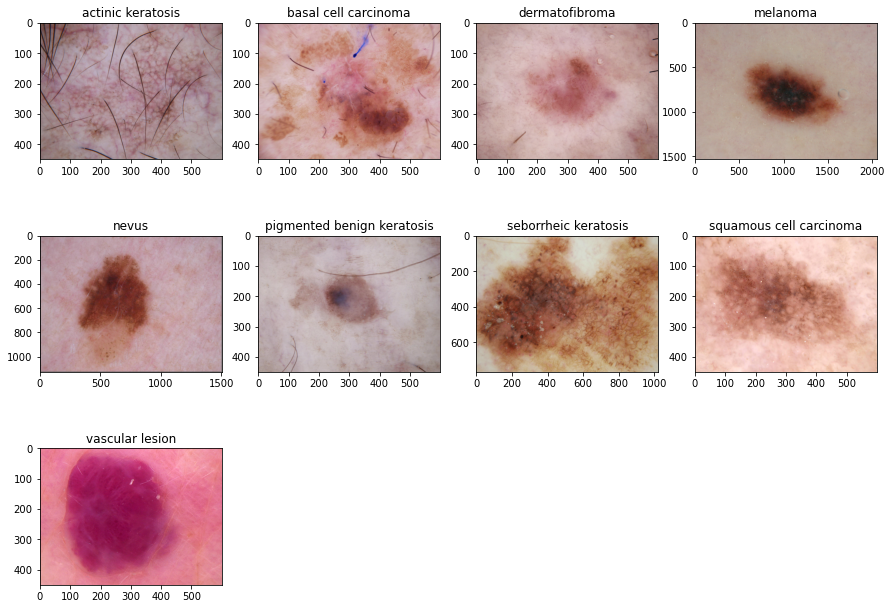

In [17]:
# visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(15,15))
for i in range(0,9): 
  plt.subplot(4, 4, i + 1)
  image = mpimg.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

### Create the model, compile and train the model


In [18]:
## using Dropout layer
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_aug, layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(num_classes, activation = "softmax"))

### Compiling the model

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      1216      
                                                                 
 conv2d_7 (Conv2D)           (None, 180, 180, 16)      6416      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 90, 90, 32)        12832     
                                                      

### Training the model

In [20]:
# train the model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 153s 3s/step - loss: 2.0541 - accuracy: 0.1836 - val_loss: 2.4598 - val_accuracy: 0.1767
Epoch 2/20
56/56 [==============================] - 150s 3s/step - loss: 2.0327 - accuracy: 0.2065 - val_loss: 1.9926 - val_accuracy: 0.2506
Epoch 3/20
56/56 [==============================] - 150s 3s/step - loss: 1.9305 - accuracy: 0.2773 - val_loss: 1.8348 - val_accuracy: 0.3266
Epoch 4/20
56/56 [==============================] - 149s 3s/step - loss: 1.8262 - accuracy: 0.3175 - val_loss: 1.8039 - val_accuracy: 0.3244
Epoch 5/20
56/56 [==============================] - 151s 3s/step - loss: 1.7439 - accuracy: 0.3555 - val_loss: 1.7938 - val_accuracy: 0.3490
Epoch 6/20
56/56 [==============================] - 139s 2s/step - loss: 1.6838 - accuracy: 0.3772 - val_loss: 1.6649 - val_accuracy: 0.4027
Epoch 7/20
56/56 [==============================] - 106s 2s/step - loss: 1.6530 - accuracy: 0.3968 - val_loss: 1.6746 - val_accuracy: 0.4027
Epoch 8/20
56

### Visualizing the results

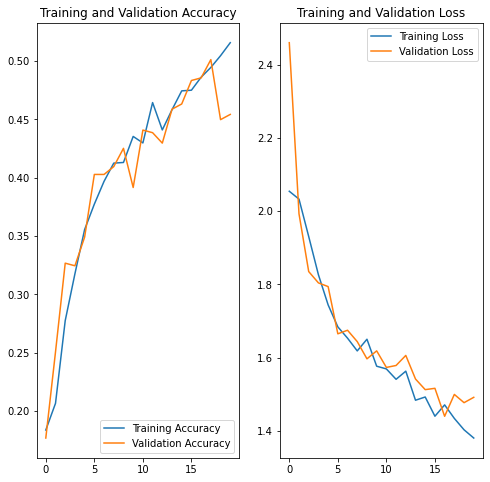

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings:
- We don't see much improvements with respect to accuracy from the base model, but we can definitely see the overfitting issue fading away due to data augmentation
- But, judging based on just 20 epochs won't give us proper conclusions

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
path_list=[]
lesion_list=[]
for i in class_names:
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
        
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,D:\Skin cancer ISIC The International Skin Ima...,actinic keratosis
1,D:\Skin cancer ISIC The International Skin Ima...,actinic keratosis
2,D:\Skin cancer ISIC The International Skin Ima...,actinic keratosis
3,D:\Skin cancer ISIC The International Skin Ima...,actinic keratosis
4,D:\Skin cancer ISIC The International Skin Ima...,actinic keratosis
...,...,...
2234,D:\Skin cancer ISIC The International Skin Ima...,vascular lesion
2235,D:\Skin cancer ISIC The International Skin Ima...,vascular lesion
2236,D:\Skin cancer ISIC The International Skin Ima...,vascular lesion
2237,D:\Skin cancer ISIC The International Skin Ima...,vascular lesion


In [23]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,D:\Skin cancer ISIC The International Skin Ima...,actinic keratosis
1,D:\Skin cancer ISIC The International Skin Ima...,actinic keratosis
2,D:\Skin cancer ISIC The International Skin Ima...,actinic keratosis
3,D:\Skin cancer ISIC The International Skin Ima...,actinic keratosis
4,D:\Skin cancer ISIC The International Skin Ima...,actinic keratosis
...,...,...
2234,D:\Skin cancer ISIC The International Skin Ima...,vascular lesion
2235,D:\Skin cancer ISIC The International Skin Ima...,vascular lesion
2236,D:\Skin cancer ISIC The International Skin Ima...,vascular lesion
2237,D:\Skin cancer ISIC The International Skin Ima...,vascular lesion


<BarContainer object of 9 artists>

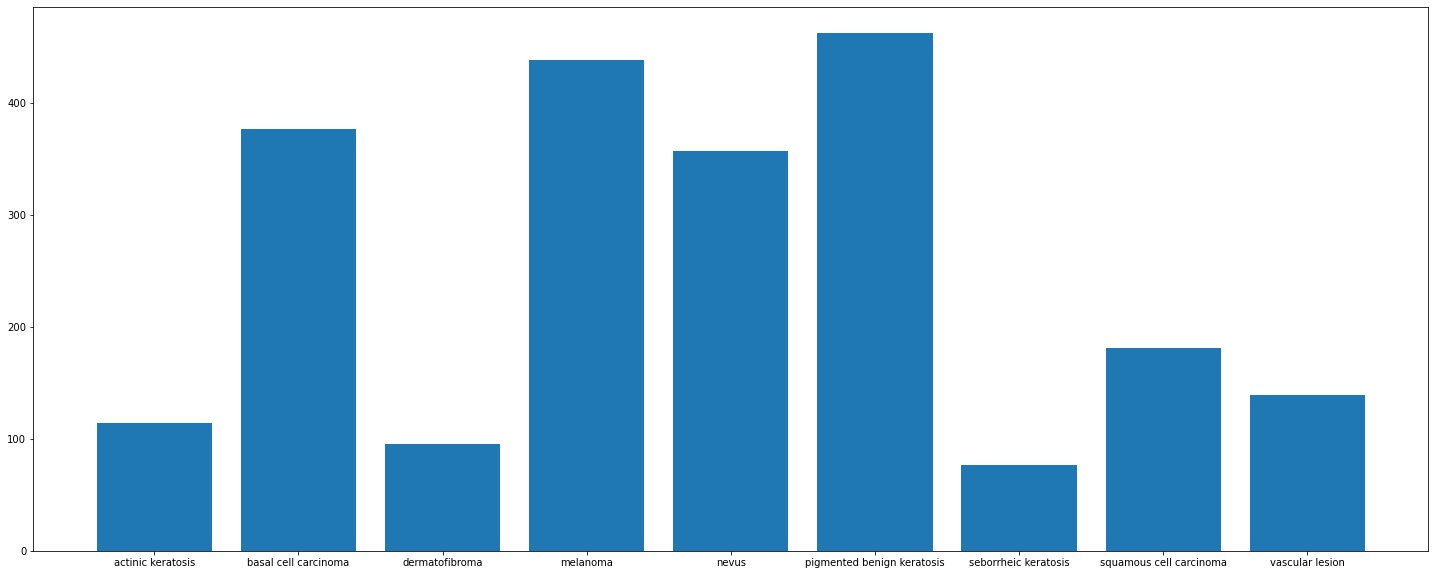

In [24]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

### Findings
- Seborrheic keratosis is having the least distribution
- Pigmented Benign keratosis is having the highest distribution of data

#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration\Train\\"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to D:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2A0A2DD4940>: 100%|█| 500/500 [00:05<00:


Initialised with 376 image(s) found.
Output directory set to D:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2A0A2E10370>: 100%|█| 500/500 [00:05<00:00, 86.51 Samples/


Initialised with 95 image(s) found.
Output directory set to D:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2A0A2E14340>: 100%|█| 500/500 [00:06<00:00, 81.53 Samples/


Initialised with 438 image(s) found.
Output directory set to D:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2A0A2D78730>: 100%|█| 500/500 [00:32<00:00, 15.52 Samples


Initialised with 357 image(s) found.
Output directory set to D:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x2A0A1CB0E20>: 100%|█| 500/500 [00:27<00:00, 18.48 Sample


Initialised with 462 image(s) found.
Output directory set to D:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2A09AE2DF40>: 100%|█| 500/500 [00:05<00:00, 86.90 Samples/


Initialised with 77 image(s) found.
Output directory set to D:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x2A0A2DB7FA0>: 100%|█| 500/500 [00:13<00


Initialised with 181 image(s) found.
Output directory set to D:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2A0A3F452B0>: 100%|█| 500/500 [00:05<00:


Initialised with 139 image(s) found.
Output directory set to D:\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2A0A2D9CE50>: 100%|█| 500/500 [00:05<00:


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [28]:
path_list = [x for x in data_dir_train.glob(os.path.join('*','output', '*.jpg'))]
path_list

[WindowsPath('D:/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025780.jpg_05a24c78-315f-48e7-9481-9ab33d7591e2.jpg'),
 WindowsPath('D:/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025780.jpg_20a27865-f1b1-47f5-b078-3ed27a65954c.jpg'),
 WindowsPath('D:/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025780.jpg_420d8f5c-6ff4-44d3-89d5-c7ddf7f0a117.jpg'),
 WindowsPath('D:/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025780.jpg_4e241503-23ef-43d4-8370-85a74842dbaf.jpg'),
 WindowsPath('D:/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025780.jpg_5b8cde80-0e4e-4eb1-be65-d450fd9ea69c.jpg'),
 WindowsPa

In [29]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in data_dir_train.glob(os.path.join('*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [30]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [31]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [32]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [33]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [34]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [35]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [50]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
num_classes = 9
#Pre-processing normalization
augmentor_model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])
# Using Batch Normalization only on raw set
augmentor_model.add(BatchNormalization())

augmentor_model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (180, 180, 32)))
augmentor_model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', activation ='relu'))
augmentor_model.add(MaxPool2D(pool_size=(2,2)))
augmentor_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
augmentor_model.add(MaxPool2D(pool_size=(2,2)))
augmentor_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
augmentor_model.add(MaxPool2D(pool_size=(2,2)))
augmentor_model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
augmentor_model.add(MaxPool2D(pool_size=(2,2)))
augmentor_model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
augmentor_model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
augmentor_model.add(Flatten())

augmentor_model.add(Dense(num_classes, activation = "softmax"))

#### Compile your model (Choose optimizer and loss function appropriately)

In [51]:
augmentor_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
augmentor_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 16)      1216      
                                                                 
 conv2d_19 (Conv2D)          (None, 180, 180, 16)      6416      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 90, 90, 32)       

#### Train your model

In [52]:
epochs = 50
## Your code goes here, use 50 epochs.
history = augmentor_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 393s 2s/step - loss: 1.7857 - accuracy: 0.3207 - val_loss: 2.2009 - val_accuracy: 0.1952
Epoch 2/50
169/169 [==============================] - 374s 2s/step - loss: 1.4459 - accuracy: 0.4590 - val_loss: 1.4849 - val_accuracy: 0.4670
Epoch 3/50
169/169 [==============================] - 387s 2s/step - loss: 1.2224 - accuracy: 0.5364 - val_loss: 1.2268 - val_accuracy: 0.5672
Epoch 4/50
169/169 [==============================] - 394s 2s/step - loss: 1.0754 - accuracy: 0.6005 - val_loss: 0.9891 - val_accuracy: 0.6451
Epoch 5/50
169/169 [==============================] - 391s 2s/step - loss: 0.8933 - accuracy: 0.6682 - val_loss: 0.8946 - val_accuracy: 0.6659
Epoch 6/50
169/169 [==============================] - 393s 2s/step - loss: 0.7554 - accuracy: 0.7277 - val_loss: 0.7533 - val_accuracy: 0.7372
Epoch 7/50
169/169 [==============================] - 394s 2s/step - loss: 0.6206 - accuracy: 0.7641 - val_loss: 0.7214 - val_accuracy: 0.7751

#### Visualize the model results

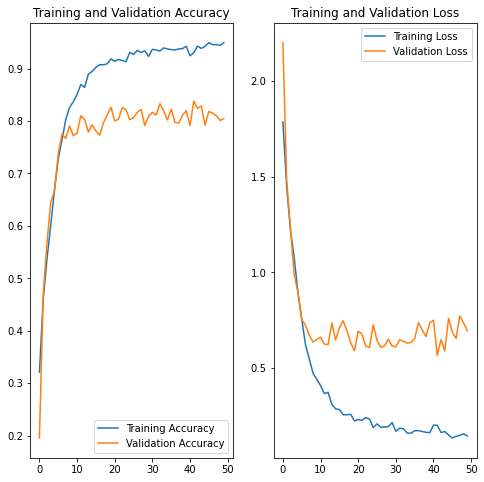

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings on the first base model
- The accuracy increases significantly to 80-90% after using class imbalance
- Model showing slightly overfitting
- Neural Network with 50 epochs showing significant pattern

In [54]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
            directory=data_dir_test,
            labels='inferred',
            image_size=(img_height,img_width),
            seed=123,
            batch_size=batch_size)

Found 118 files belonging to 9 classes.


#### Augmentor model with class imbalance handled, has highest validation accuracy so let's try it on test dataset

In [55]:
res = augmentor_model.evaluate(test_ds)

4/4 [==============================] - 4s 341ms/step - loss: 5.4510 - accuracy: 0.3305


The test accuracy with augmentor model is ~0.33 and loss function is 5.45

Class imbalance has been resolved but model still seems to overfit